<a href="https://colab.research.google.com/github/MahlerTom/Siamese-Neural-Networks/blob/master/IntroToDeepEx02_Tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import os

# Clone the entire repo.
!git clone -s git://github.com/MahlerTom/Siamese-Neural-Networks.git Siamese-Neural-Networks
repo_path = os.path.join(os.getcwd(), 'Siamese-Neural-Networks')
train_path = os.path.join(repo_path, 'data', 'train')
test_path = os.path.join(repo_path, 'data', 'test')

fatal: destination path 'Siamese-Neural-Networks' already exists and is not an empty directory.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

Loaded 6685 image paths
##########################################
Printing Example Images



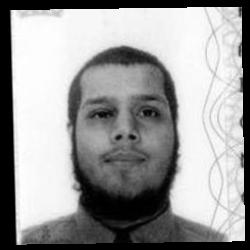

Asif_Hanif_0001



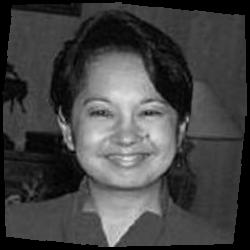

Gloria_Macapagal_Arroyo_0001



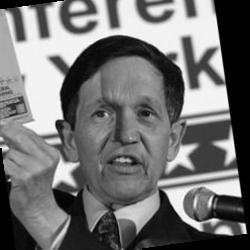

Dennis_Kucinich_0007

##########################################
Loaded 6685 image paths
##########################################
Printing Example Images



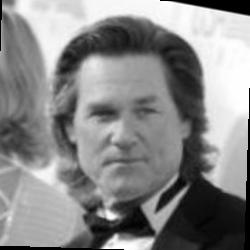

Kurt_Russell_0001



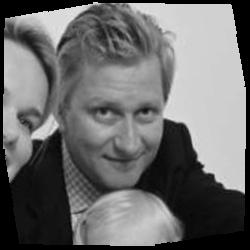

Prince_Philippe_0001



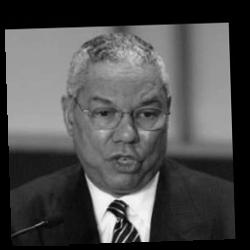

Colin_Powell_0134

##########################################
['Abdoulaye_Wade_0002', 'Rachel_Wadsworth_0001', 'Jose_Maria_Aznar_0016']
['content/Siamese-Neural-Networks/data/train/Abdoulaye_Wade_0002.jpg', 'content/Siamese-Neural-Networks/data/train/Rachel_Wadsworth_0001.jpg', 'content/Siamese-Neural-Networks/data/train/Jose_Maria_Aznar_0016.jpg']
[('Aaron_Peirsol_0001', 'Aaron_Peirsol_0002', 1), ('Aaron_Peirsol_0003', 'Aaron_Peirsol_0004', 1), ('Aaron_Sorkin_0001', 'Aaron_Sorkin_0002', 1)]


In [132]:
import pathlib
import random
import IPython.display as display

def load_data(data_path, labels_file, print_imgs=3):
  data_root = pathlib.Path(data_path)
  
  data_paths = list(data_root.glob('*'))
  data_paths = [str(path) for path in data_paths]
  random.shuffle(data_paths)
  data_count = len(data_paths)
  print('Loaded', data_count, 'image paths')
  if print_imgs > 0:
    print('##########################################')
    print('Printing Example Images')
    print()
    
    for n in range(print_imgs):
      image_path = random.choice(data_paths)
      display.display(display.Image(image_path))
      print(image_path.split('/')[-1][:-4])
      print()
      
    print('##########################################')
    
  rel_path = os.path.join(*data_paths[0].split('/')[:-1])
  data_names = [ tip.split('/')[-1][:-4] for tip in data_paths ]
  data_paths_names_dict = { name: os.path.join(rel_path, name + '.jpg') for name in data_names }
    
  labels = list()
  with open(labels_file) as lf:
    for l in lf:
      l = l[:-1].split('\t')
      if len(l) == 3:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[0] + '_' + l[2].zfill(4), 1)))
      if len(l) == 4:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[2] + '_' + l[3].zfill(4), 0)))
        
  return data_paths_names_dict, labels


train_paths_names_dict, train_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'trainPairs.txt'))

test_paths_names_dict, test_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'testPairs.txt'))
print(list(train_paths_names_dict.keys())[:3])
print(list(train_paths_names_dict.values())[:3])
print(train_labels[:3])

In [0]:
ds_train = dict()
for tp in os.listdir(train_path):
  ds_train[tp[:-4]] = 

Mitsou_Gelinas_0001
Richard_Branson_0002
Yasser_Arafat_0007
Jennifer_Garner_0009
George_W_Bush_0165
Carlos_Menem_0006
John_Ashcroft_0053
Roh_Moo-hyun_0019
George_W_Bush_0278
George_W_Bush_0363
AJ_Cook_0001
Natalia_Dmitrieva_0001
Kim_Ryong-sung_0007
Adolfo_Rodriguez_Saa_0002
Joschka_Fischer_0006
Jerry_Lewis_0001
Elijah_Wood_0003
Fernando_Henrique_Cardoso_0008
Andrew_Weissmann_0001
Mike_Scioscia_0002
Ashanti_0002
Carlos_Menem_0004
Steve_Nash_0003
Sim_Yong_0001
Alejandro_Toledo_0028
Arnie_Boehm_0001
Gong_Ruina_0001
Nicolas_Cage_0002
Jack_Straw_0003
Alex_Holmes_0001
Albrecht_Mentz_0001
Tony_Blair_0079
John_Paul_II_0001
Edmund_Stoiber_0002
Anders_Fogh_Rasmussen_0001
Roh_Moo-hyun_0005
Justin_Guarini_0003
Emmanuelle_Beart_0003
Claudia_Pechstein_0002
Bill_Clinton_0002
Serena_Williams_0023
Nadia_Forte_0001
Rick_Barnes_0003
Marc_Grossman_0004
Gloria_Macapagal_Arroyo_0030
Sheldon_Silver_0001
Eduard_Shevardnadze_0001
Ben_Wallace_0001
Yu_Shyi-kun_0002
Audrey_Lacroix_0001
Tiger_Woods_0003
Vladimir_P

In [0]:
for f in os.listdir(train_path):
  print(f)

Mitsou_Gelinas_0001.jpg
Richard_Branson_0002.jpg
Yasser_Arafat_0007.jpg
Jennifer_Garner_0009.jpg
George_W_Bush_0165.jpg
Carlos_Menem_0006.jpg
John_Ashcroft_0053.jpg
Roh_Moo-hyun_0019.jpg
George_W_Bush_0278.jpg
George_W_Bush_0363.jpg
AJ_Cook_0001.jpg
Natalia_Dmitrieva_0001.jpg
Kim_Ryong-sung_0007.jpg
Adolfo_Rodriguez_Saa_0002.jpg
Joschka_Fischer_0006.jpg
Jerry_Lewis_0001.jpg
Elijah_Wood_0003.jpg
Fernando_Henrique_Cardoso_0008.jpg
Andrew_Weissmann_0001.jpg
Mike_Scioscia_0002.jpg
Ashanti_0002.jpg
Carlos_Menem_0004.jpg
Steve_Nash_0003.jpg
Sim_Yong_0001.jpg
Alejandro_Toledo_0028.jpg
Arnie_Boehm_0001.jpg
Gong_Ruina_0001.jpg
Nicolas_Cage_0002.jpg
Jack_Straw_0003.jpg
Alex_Holmes_0001.jpg
Albrecht_Mentz_0001.jpg
Tony_Blair_0079.jpg
John_Paul_II_0001.jpg
Edmund_Stoiber_0002.jpg
Anders_Fogh_Rasmussen_0001.jpg
Roh_Moo-hyun_0005.jpg
Justin_Guarini_0003.jpg
Emmanuelle_Beart_0003.jpg
Claudia_Pechstein_0002.jpg
Bill_Clinton_0002.jpg
Serena_Williams_0023.jpg
Nadia_Forte_0001.jpg
Rick_Barnes_0003.jpg
Ma

In [0]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

/content/cloned-repo/Siamese-Neural-Networks/Siamese-Neural-Networks/Siamese-Neural-Networks/Siamese-Neural-Networks2/Siamese-Neural-Networks
/content/cloned-repo/Siamese-Neural-Networks/Siamese-Neural-Networks/Siamese-Neural-Networks/Siamese-Neural-Networks2
/content/cloned-repo/Siamese-Neural-Networks/Siamese-Neural-Networks/Siamese-Neural-Networks/Siamese-Neural-Networks2/Siamese-Neural-Networks/data
test  train  unused


In [0]:
train_pairs = []
train_names = set()
with open("trainPairs.txt") as train:
  train_files = train.readlines()[1:]
  
for pair in train_files:
  pair = pair[:-1].split('\t')
  if len(pair) == 3:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = name1
    id2 = pair[2].zfill(4)
    
    train_names.add(name1)
    
  elif len(pair) == 4:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = pair[2]
    id2 = pair[3].zfill(4)
    
    train_names.add(name1)
    train_names.add(name2)
  train_pairs.append((name1 + '_' + id1, name2 + '_' + id2))
train_names = list(train_names)

In [0]:
test_pairs = []
test_names = set()
with open("testPairs.txt") as test:
  test_files = test.readlines()[1:]
  
for pair in test_files:
  pair = pair[:-1].split('\t')
  if len(pair) == 3:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = name1
    id2 = pair[2].zfill(4)
    
    test_names.add(name1)
    
  elif len(pair) == 4:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = pair[2]
    id2 = pair[3].zfill(4)
    
    test_names.add(name1)

    test_names.add(name2)
  test_pairs.append((name1 + '_' + id1, name2 + '_' + id2))
test_names = list(test_names)

In [0]:
src = "lfw2/"
train_dir = "data/train/"
test_dir = "data/test/"

for name in train_names:
  print("Moving " + name + "...")
  shutil.copytree(src + name, train_dir + name)
  

Moving Charlotte_Rampling...


FileNotFoundError: ignored